<a href="https://colab.research.google.com/github/NicolasManuelKoch/cap-comp215/blob/main/project_1__Nicolas_Manuel_Koch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project #1**

**Instructions:**

Below you'll find parameter assignments named "locationcode_query_change", "locationcode_querylocationcode_query", "date_query" and "metric_query". Each one of these make it possible to get data by using an API from opencovid.ca.
You can change the kind of data that is being displayed in the dashboard, once the code is run, by changing the input the following way:


*locationcode_query_change*: Here you can change if you want to gather data from the whole of Canada, or just from a province or health region. If you want to get data from Canada just type in "can". If you want to change it to a province, type in "pt". And finally, if you want to change it to a health region, type in "hr"

*locationcode_query: *The way to change this one, depends on what you changed "locationcode_query_change" to. For example, if before you wanted to gather data for Canada, you can leave this one empty. But if you changed it to "pt", or "hr" you have to find the appropriate code for the province or health region you want to take the data from, meaning from https://github.com/ccodwg/CovidTimelineCanada/blob/main/geo/pt.csv or https://github.com/ccodwg/CovidTimelineCanada/blob/main/geo/hr.csv respectively.

*date_query:* Here you can type in the date from when you want to gather the data in the format YYYY-MM-DD (for example "2021-01-01")

*metric_query:* Here you can filter specific metrics such as cases, or deaths. Be careful though, because not all provinces or health regions have data available for all respecive metrics, so changing it from "all" to something else, might cause an error.

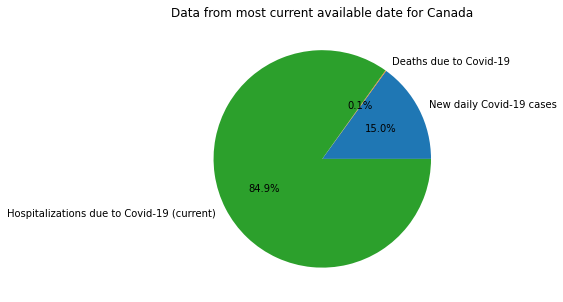

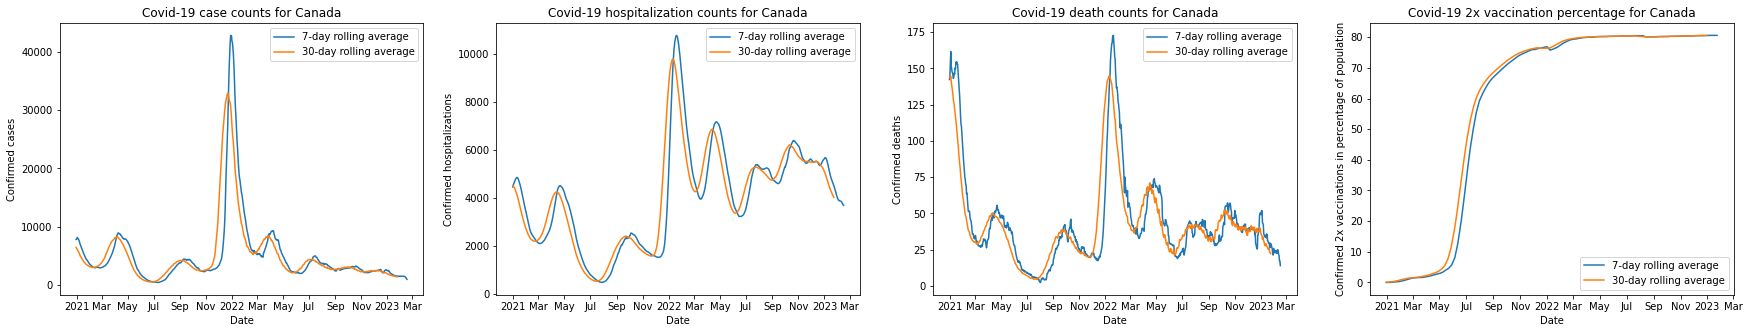

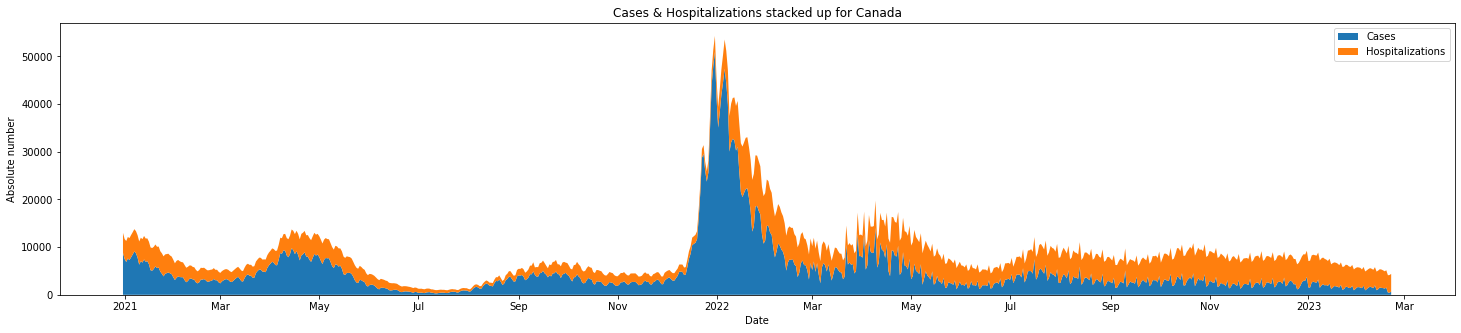

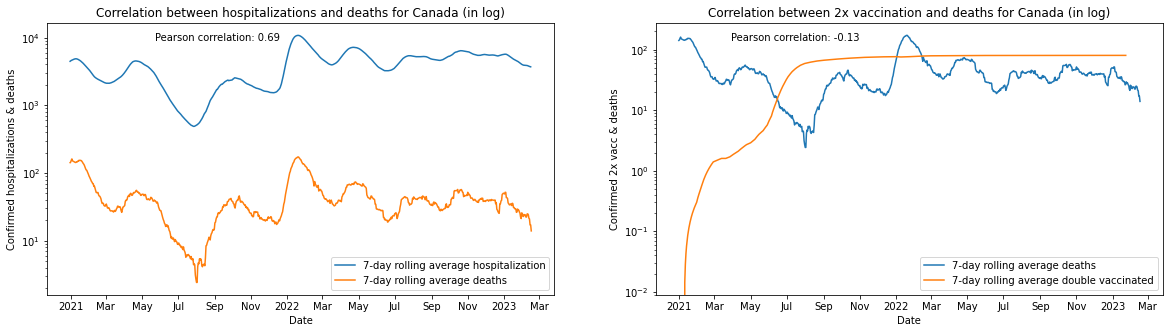

In [101]:
import datetime, json, requests
import matplotlib.pyplot as plt
import  matplotlib.dates as mdates
import numpy as np
from IPython.display import display, HTML
from pprint import pprint    


locationcode_query_change = "can" #pt (return data for a specific province/territory, add to locationcode_query), hr (return data for a specific health region, add to locationcode_query), or can (return data for all of canada) if you change this to more specific values, you have to change locationcode_query as well
locationcode_query = ""  #take code from https://github.com/ccodwg/CovidTimelineCanada/blob/main/geo/pt.csv or https://github.com/ccodwg/CovidTimelineCanada/blob/main/geo/hr.csv
date_query = "2020-12-31" #get data from after this date up to the latest data entry
metric_query = "all" #get data for all available information (deaths, cases, hospitalizations) or filter specific metrics

#assigns the respective title to the graph depending on the choosen parameters
if locationcode_query_change == "can": 
  graphname = "Canada"
elif locationcode_query_change == "pt":
  graphname = locationcode_query
else:
  graphname = "health region with code: " + locationcode_query

#make the query by putting together the web-adresse and choosen parameters
query = 'https://api.opencovid.ca/timeseries?stat=' + metric_query + '&loc=' + locationcode_query + '&geo=' + locationcode_query_change +'&after=' + date_query

response = requests.request("GET", query, headers={}, data={})

result = json.loads(response.text)

cases = result['data']['cases'] # List Comprehension: extract the cases from data
case_dates = [daily['date'] for daily in cases]     # List Comprehension: extract the case date strings
n_cases = [daily['value_daily'] for daily in cases] # List Comprehension:  extract the case counts

deaths = result['data']['deaths']# List Comprehension: extract the deaths from data
death_dates = [daily['date'] for daily in deaths]     # List Comprehension #1: extract the case date strings
n_deaths = [daily['value_daily'] for daily in deaths] # List Comprehension #2:  extract the case counts

# We only want to get data for hospitalizations if the locationcode_query_change is "pt" or "can", as for hr sometimes it doesn't exist
if locationcode_query_change == "can" or locationcode_query_change == "pt": 
  hospitalizations = result['data']['hospitalizations']
  hospitalization_dates = [daily['date'] for daily in hospitalizations]     # List Comprehension #1: extract the case date strings
  n_hospitalizations = [daily['value'] for daily in hospitalizations] # List Comprehension #2:  extract the case counts

# We only want to get data for hospitalizations if the locationcode_query_change is "pt" or "can", as for hr sometimes it doesn't exist
if locationcode_query_change == "can" or locationcode_query_change == "pt":
  vaccine2 = result['data']['vaccine_coverage_dose_2']
  vaccine2_dates = [daily['date'] for daily in vaccine2]     # List Comprehension #1: extract the case date strings
  n_vaccine2 = [daily['value'] for daily in vaccine2] # List Comprehension #2:  extract the percentage that is double vaccinated

# parse a datetime object from a string by supplying the correct "format" string.
datetime_objects_cases = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in case_dates]  # Dates for Cases in BC
datetime_objects_deaths = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in death_dates]  # Dates for Deaths in BC
# We only want to get data for hospitalizations if the locationcode_query_change is "pt" or "can", as for hr sometimes it doesn't exist
if locationcode_query_change == "can" or locationcode_query_change == "pt":
  datetime_objects_BC_hospitalizations = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in hospitalization_dates]  # Dates for Cases in BC
  datetime_objects_BC_vaccine2 = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in vaccine2_dates]  # Dates for Deaths in BC

# but we only need the "date" part...
dates_cases = [dt.date() for dt in datetime_objects_cases]
dates_deaths = [dt.date() for dt in datetime_objects_deaths]
# We only want to get data for hospitalizations if the locationcode_query_change is "pt" or "can", as for hr sometimes it doesn't exist
if locationcode_query_change == "can" or locationcode_query_change == "pt":
  dates_hospitalizations = [dt.date() for dt in datetime_objects_cases]
  dates_vaccine2 = [dt.date() for dt in datetime_objects_deaths]

#the location "hr" doesn't offer vaccination or hospitalization data, in order to not get an error, we have to assign something to the values we later use in the functions
if locationcode_query_change == "hr":
  n_hospitalizations = [1, 1, 1]
  n_vaccine2 = [1, 1, 1]
  dates_hospitalizations = dates_cases
  dates_vaccine2 = dates_cases

def format_date_axis(ax):
  #format the dates shown on the x-axis of given axes, ax 
  locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
  formatter = mdates.ConciseDateFormatter(locator)
  ax.xaxis.set_major_locator(locator)
  ax.xaxis.set_major_formatter(formatter)

def seven_day_average(BC_data):
  #compute a 7-day average
  average2 = []
  windowsize = 7
  adjust_for_windowsize = windowsize - 1
  for i in range(len(BC_data)-adjust_for_windowsize): # Repeat for the amount of integers minus the number needed to get a full set of "windowsize" in the end.
    average = BC_data[i:i+windowsize] # Get a list with 7 numbers.
    average2 = average2 + [(sum(average))/windowsize] # Calcuate the average of the list created above by adding all numbers together and deviding by windowsize.
  return average2

def thirty_day_average(BC_data):
  #compute a 30-day average
  average2 = []
  windowsize = 30
  adjust_for_windowsize = windowsize - 1
  for i in range(len(BC_data)-adjust_for_windowsize): # Repeat for the amount of integers minus the number needed to get a full set of "windowsize" in the end.
    average = BC_data[i:i+windowsize] # Get a list with 7 numbers.
    average2 = average2 + [(sum(average))/windowsize] # Calcuate the average of the list created above by adding all numbers together and deviding by windowsize.
  return average2

def make_graph(list_of_cases, dates_of_cases, list_of_hospitalizations, dates_of_hospitalizations, list_of_deaths, dates_of_deaths, list_of_vaccine2, dates_of_vaccine2, title, ylabel):
  #make the graphs and display them as subplots next to each other, so it looks nicely formatted
  list_of_data = [list_of_cases, list_of_hospitalizations, list_of_deaths, list_of_vaccine2] # create list of cases, hosp, deaths and 2x vaccinations
  list_of_dates = [dates_of_cases, dates_of_hospitalizations, dates_of_deaths, dates_of_vaccine2] # create corresponding date list
  seven_day_average_computed = []
  thirty_day_average_computed =  []
  seven_day_plot = []
  thirty_day_plot = []
  for x in range(4): #adjust for new length of list
    seven_day_average_computed = seven_day_average_computed + [seven_day_average(list_of_data[x][0:len(list_of_dates[x])])]
    thirty_day_average_computed = thirty_day_average_computed + [thirty_day_average(list_of_data[x][0:len(list_of_dates[x])])]
    seven_day_plot = seven_day_plot + [list_of_dates[x][0:len(seven_day_average_computed[x])]] # Adjust for new length of list.
    thirty_day_plot = thirty_day_plot + [list_of_dates[x][0:len(thirty_day_average_computed[x])]] # Adjust for new length of list. 
  fig, ax = plt.subplots(1, 4, figsize=(30, 5)) #set up subplot and size of figure
  title_list = [f"Covid-19 case counts for {title}", f"Covid-19 hospitalization counts for {title}", f"Covid-19 death counts for {title}", f"Covid-19 2x vaccination percentage for {title}"] # create list of titles
  ylabel_list = ["Confirmed cases", "Confirmed hospitalizations", "Confirmed deaths", "Confirmed 2x vaccinations in percentage of population"] #create list of ylabels
  for x in range(4): 
    #set up subplots with label, title etc.
    format_date_axis(ax[x])
    ax[x].plot(seven_day_plot[x], seven_day_average_computed[x], label='7-day rolling average')  # Plot some data on the axes (the 7 day rolling average).
    ax[x].plot(thirty_day_plot[x], thirty_day_average_computed[x], label='30-day rolling average')  # Plot some data on the axes (the 7 day rolling average).
    ax[x].set_xlabel('Date')  # Add an x-label to the axes.
    ax[x].set_ylabel(ylabel_list[x])  # Add a y-label to the axes.
    ax[x].set_title(title_list[x])  # Add a title to the axes.
    ax[x].legend()

def make_graph_correlation(list_of_data_A, dates_of_data_A, name_dataA, list_of_data_B, dates_of_data_B, name_dataB, list_of_data_C, dates_of_data_C, name_dataC, title1, title2, ylabel1, ylabel2):
  seven_day_average_computed_A = seven_day_average(list_of_data_A[0:len(dates_of_data_A)])# Adjust for new length of list.
  seven_day_average_computed_B = seven_day_average(list_of_data_B[0:len(dates_of_data_B)])# Adjust for new length of list.
  seven_day_average_computed_C = seven_day_average(list_of_data_C[0:len(dates_of_data_C)])# Adjust for new length of list.
  seven_day_plot_A = dates_of_data_A[0:len(seven_day_average_computed_A)] # Adjust for new length of list.
  seven_day_plot_B = dates_of_data_B[0:len(seven_day_average_computed_B)] # Adjust for new length of list.
  seven_day_plot_C = dates_of_data_C[0:len(seven_day_average_computed_C)] # Adjust for new length of list.
  fig, ax = plt.subplots(1, 2, figsize=(20, 5)) #set up subplot and size of figure
  ax[0].set_title(title1)  # Add a title to the axes.
  ax[1].set_title(title2)  # Add a title to the other axes.
  ax[0].set_ylabel(ylabel1)  # Add a y-label to the axes.
  ax[1].set_ylabel(ylabel2)  # Add a y-label to the other axes.
  ax[0].plot(seven_day_plot_A, seven_day_average_computed_A, label=f'7-day rolling average {name_dataA}')  # Plot some data on the axes (the 7 day rolling average).
  ax[0].plot(seven_day_plot_B,seven_day_average_computed_B, label=f'7-day rolling average {name_dataB}')  # Plot some other data on the axes (the 7 day rolling average).
  ax[1].plot(seven_day_plot_B, seven_day_average_computed_B, label=f'7-day rolling average {name_dataB}')  # Plot some data on the axes (the 7 day rolling average).
  ax[1].plot(seven_day_plot_C,seven_day_average_computed_C, label=f'7-day rolling average {name_dataC}')  # Plot some other data on the axes (the 7 day rolling average).
  for x in range(2):
    format_date_axis(ax[x]) #format date
    ax[x].set_yscale('log') #et scale to log mode
    ax[x].set_xlabel('Date')  # Add an x-label to the axes.
    ax[x].legend() #add a legend
  len_smallest1 = min(len(seven_day_average_computed_A), len(seven_day_average_computed_B)) #make sure the lists match up in length
  len_smallest2 = min(len(seven_day_average_computed_B), len(seven_day_average_computed_C)) #make sure the lists match up in length
  correlation1 = np.corrcoef(seven_day_average_computed_A[0:len_smallest1], seven_day_average_computed_B[0:len_smallest1]) #find the correlation
  correlation2 = np.corrcoef(seven_day_average_computed_B[0:len_smallest2], seven_day_average_computed_C[0:len_smallest2]) #find the correlation
  correlation_pearson1 = correlation1[0, 1] #get the pearson correlation index of the two different input sets of data 
  correlation_pearson2 = correlation2[0, 1] #get the pearson correlation index of the two different input sets of data 
  plt.figtext(.2, .83, f"Pearson correlation: {round(correlation_pearson1, 2)}") #display the pearson correlation number inside the left graphmodule
  plt.figtext(.6, .83, f"Pearson correlation: {round(correlation_pearson2, 2)}") #display the pearson correlation number inside the right graphmodule


def stackplot(dates, dataA, dataB, dataA_name, dataB_name, title):
  fig, ax = plt.subplots(figsize=(25, 5)) #set up subplot and size of figure
  len_smallest = min(len(dates), len(dataA), len(dataB)) #make sure the lists match up in length
  ax.stackplot(dates[0:len_smallest], dataA[0:len_smallest], dataB[0:len_smallest], labels=[dataA_name, dataB_name]) #make sure the lists match up in length
  ax.legend(loc='upper right') #create a legend and set it in the upper right corner
  ax.set_xlabel('Date') #set the xlabel
  ax.set_ylabel('Absolute number') #set the ylabel
  ax.set_title(title) #set the title
  format_date_axis(ax) #formate the date
  plt.show()

def piechart_last_data(new_n_cases, n_deaths, n_hospitalizations):
  label = 'New daily Covid-19 cases', 'Deaths due to Covid-19', 'Hospitalizations due to Covid-19 (current)' #create the labels
  min_len = min(len(new_n_cases), len(n_deaths), len(n_hospitalizations)) #make sure the lists match up in length 
  sizes = [new_n_cases[0:min_len][-1], n_deaths[0:min_len][-1], n_hospitalizations[0:min_len][-1]] #make sure the lists match up in length
  fig, ax = plt.subplots(figsize=(5, 5)) #set up subplot and size of figure
  ax.pie(sizes, labels=label, autopct='%1.1f%%') #set up the pie
  ax.set_title(f"Data from most current available date for {graphname}") #set up the title

#call all of the functions
piechart_last_data(n_cases, n_deaths, n_hospitalizations)
make_graph(n_cases, dates_cases, n_hospitalizations, dates_hospitalizations, n_deaths, dates_deaths, n_vaccine2, dates_vaccine2, f"{graphname}", "Confirmed cases")
stackplot(dates_cases, n_cases, n_hospitalizations, "Cases", "Hospitalizations", f"Cases & Hospitalizations stacked up for {graphname}")
make_graph_correlation(n_hospitalizations, dates_hospitalizations, "hospitalization", n_deaths, dates_deaths, "deaths", n_vaccine2, dates_vaccine2, "double vaccinated", f"Correlation between hospitalizations and deaths for {graphname} (in log)", f"Correlation between 2x vaccination and deaths for {graphname} (in log)", "Confirmed hospitalizations & deaths", "Confirmed 2x vacc & deaths")



**Interpretation:**

1. The first figure shows the most current data (specific day) and displays that data in form of a pie chart including current cases, deaths and hospitalizations.


2. The second row shows case counts, hospitalization counts, death counts and double vaccination percentage of the entire population in form of a 7-day and 30-day average, with the date range on the x axis and the counts on the y axis.

3. The third row shows the case and hospitalization counts for the choosen location stacked up. This helps show the delay in hospitalizations as opposed to the cases. Hospitalizations usually pick up 2 weeks after cases have increased.

4. The last row is the most interesting one in my opinion. It shows the correlation between hospitalizations and deaths & 2x vaccinations and deaths in the choosen location. -1 is the most negative correlation, meaning if one goes up, the other goes down. 0 is no correlation, meaning the two datasets are not looking like they are influenced by one another. 1 is the most positive correlation, meaning if one goes up, the other one goes up the same way.
Now, we can see that for most locations, the correlation between 2x vaccinations and deaths aren't very negative at all, sometimes even slightly positive, which shouldn't be as vaccinations should help people be protected from death. Of course, this is only a part of data and doesn't include important parameters such as cases or variants etc., but nonetheless it is interesting. 

**Attention**: If you chose the parameter "hr" instead of "pt" or "can", then the data might not be fully accurate, as the "hr" dataset is incomplete and only shows the cases and deaths, but carries no data regarding hospitalizations or vaccinations!